In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import random
import librosa
import gc

In [44]:
def split_song(name, new_len=3, num_samples=10, visualize=False):
    y, sr = librosa.load(name)
    num_poss_samples = (len(y) // sr) // new_len
    #print(num_poss_samples)
    if num_poss_samples < num_samples:
        num_samples = num_poss_samples
    #print(sr)
    #print(len(y))
    sr_len = (new_len * sr) - 1
    visualized = False
    
    i = 0
    curr_track = 0
    chunks = set()
    songs = dict()
    while (curr_track < num_samples):
        #Assumes all tracks are in .wav format

        
        found = False
        start_chunk = -1
        if num_samples < num_poss_samples:
            while start_chunk == -1 or start_chunk in chunks:
                start_chunk = random.randint(0,num_poss_samples-1)
        else:
            start_chunk = i
            i += 1
        #print("Chunk: " + str(start_chunk))
        chunks.add(start_chunk)

        track_name = name[:-3] + str(curr_track) + '.wav'

        start_val = start_chunk * sr_len
        
        y_new = y[start_val:(start_val+sr_len)]

        librosa.feature.chroma_stft(y=y_new,sr=sr)
        if visualize and not visualized:
            S = np.abs(librosa.stft(y_new))
            chroma = librosa.feature.chroma_stft(S=S, sr=sr)
            print(chroma.shape)

            fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,8))
            ax[0].set_title('Short-Term Fourier Transform of Song')
            img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                        y_axis='log', x_axis='time', ax=ax[0])
            fig.colorbar(img, ax=[ax[0]], format='%+2.0f dB')
            ax[1].set_title('Chroma STFT')
            img1 = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
            fig.colorbar(img1, ax=[ax[1]])

    
            cent = librosa.feature.spectral_centroid(y=y_new, sr=sr)
            freqs, times, D = librosa.reassigned_spectrogram(y_new, fill_nan=True)
            times = librosa.times_like(cent)
            fig1, ax1 = plt.subplots()
            img2 = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                    y_axis='log', x_axis='time', ax=ax1)
            ax1.plot(times, cent.T, label='Spectral centroid', color='w')
            ax1.legend(loc='upper right')
            ax1.set(title='Spectral Centroid')
            fig1.colorbar(img2, ax=ax1, format='%+2.0f dB')

            

            fig2, ax2 = plt.subplots()
            spectral_flatness = librosa.feature.spectral_flatness(y=y_new)
            
            ax2.plot(spectral_flatness.T, label='Spectral Flatness', color='r')
            ax2.set_xlabel('time')
            ax2.set_ylabel('spectral flatness')
            ax2.set(title='Spectral Flatness')
            ax2.legend(loc='upper right')



            fig3, ax3 = plt.subplots()
            rolloff = librosa.feature.spectral_rolloff(y=y_new, sr=sr)
            librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                    y_axis='log', x_axis='time', ax=ax3)
            ax3.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.85)')
            ax3.legend(loc='upper right')
            ax3.set(title='Roll Off Frequency')

            fig4, ax4 = plt.subplots()

            mfcc = librosa.feature.mfcc(y=y_new, sr=sr, n_mfcc=20)

            librosa.display.specshow(mfcc, x_axis='time', sr=sr)
            ax4.set_title('MFCC (1-20)')
            ax4.set_yticks(np.arange(0,20))
            ax4.set_yticklabels(np.arange(1,21))

            # Show the plot
            plt.show()

            visualized = True

        features = {
            "chroma_stft_mean": np.mean(librosa.feature.chroma_stft(y=y_new, sr=sr)),
            "chroma_stft_var": np.var(librosa.feature.chroma_stft(y=y_new, sr=sr)),
            "spectral_centroid_mean": np.mean(librosa.feature.spectral_centroid(y=y_new, sr=sr)),
            "spectral_centroid_var": np.var(librosa.feature.spectral_centroid(y=y_new, sr=sr)),
            "spectral_flatness_mean": np.var(librosa.feature.spectral_flatness(y=y_new)),
            "spectral_flatness_var": np.var(librosa.feature.spectral_flatness(y=y_new)),
            "rolloff_mean": np.mean(librosa.feature.spectral_rolloff(y=y_new, sr=sr)),
            "rolloff_var": np.var(librosa.feature.spectral_rolloff(y=y_new, sr=sr)),
        }

        mfcc = librosa.feature.mfcc(y=y_new, sr=sr)

        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_var = np.var(mfcc, axis=1)
        for j in range(1,21):
            features['mfcc' + str(j) + '_mean'] = mfcc_mean[j-1]
            features['mfcc' + str(j) + '_var'] = mfcc_var[j-1]
        
        songs[track_name] = features

        curr_track += 1
    
    del y
    gc.collect()

    return songs

(12, 130)


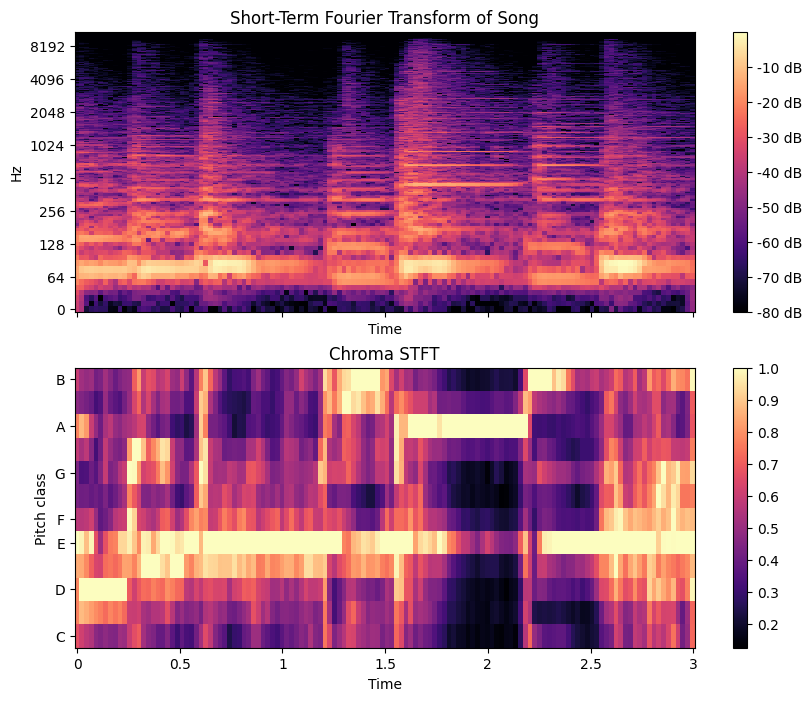

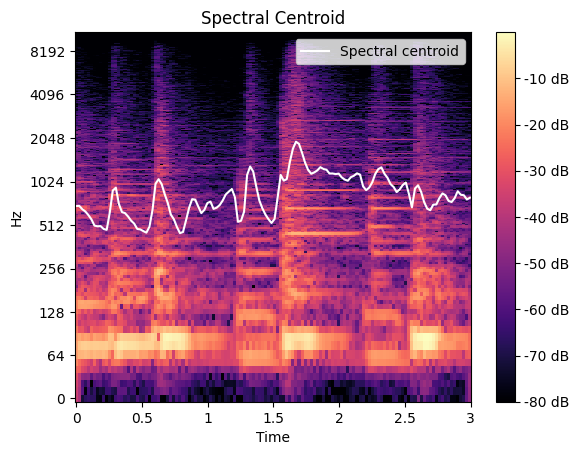

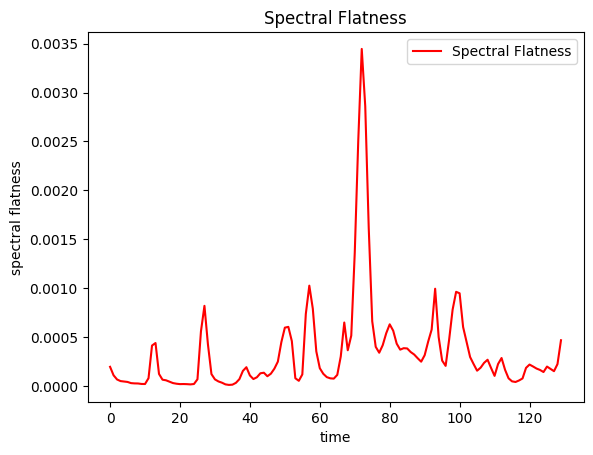

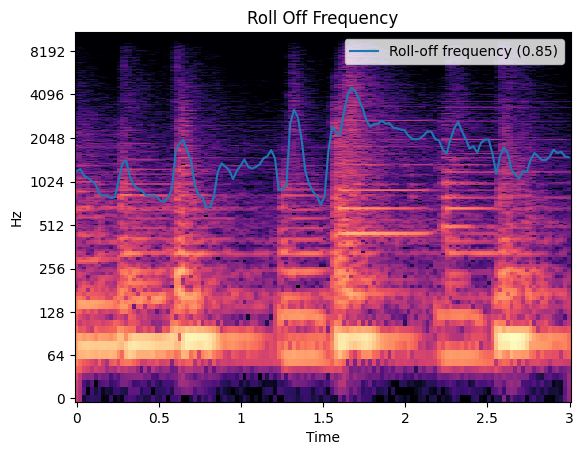

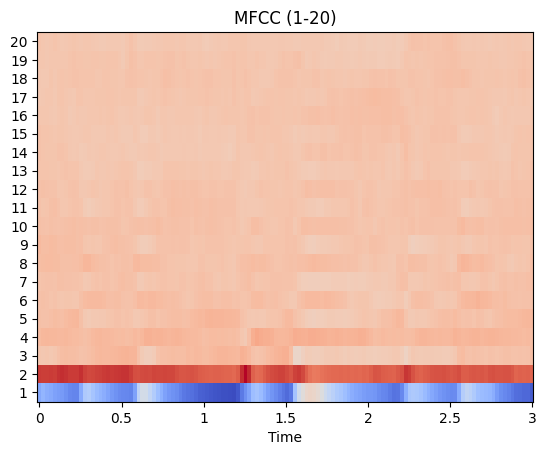

48


In [45]:
x = split_song('./Data/genres_original/blues/blues.00003.wav', visualize=True)
print(len(x['./Data/genres_original/blues/blues.00003.0.wav']))

(12, 130)


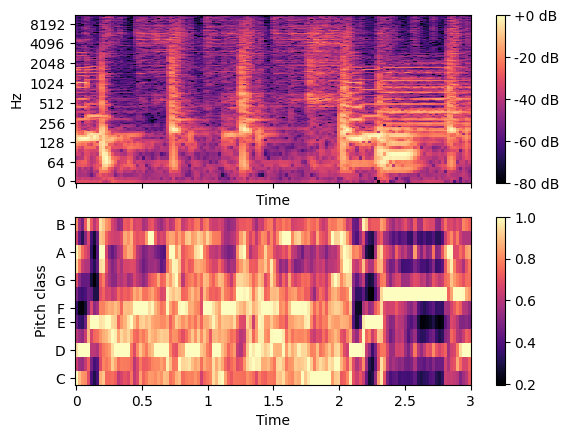

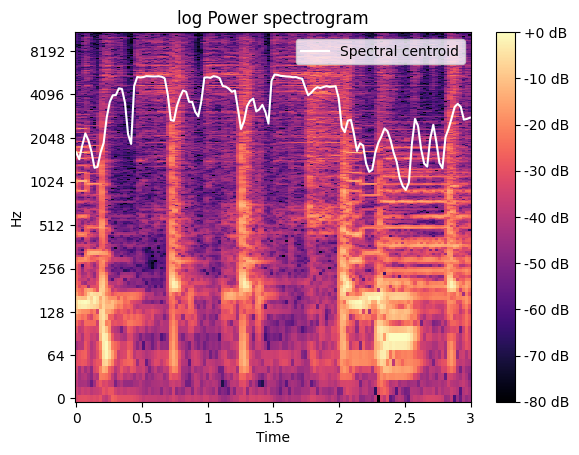

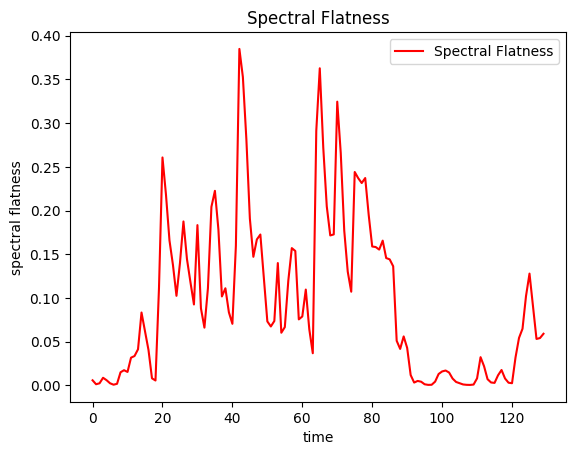

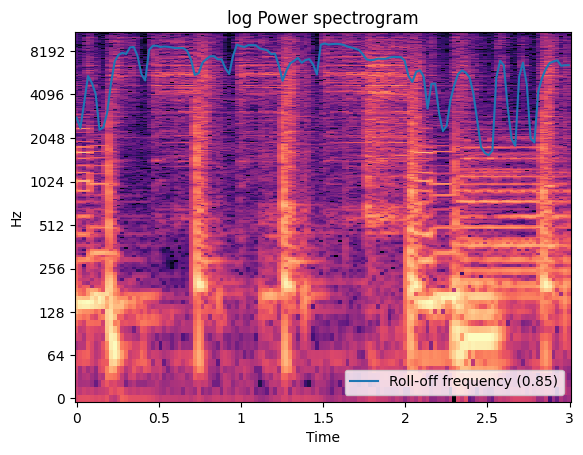

In [23]:
x = split_song('./Data/genres_original/disco/disco.00000.wav', visualize=True)

In [19]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    # Combine features (time, features)
    features = np.vstack([chroma_stft, spectral_centroid, spectral_flatness, spectral_rolloff, mfcc])
    return features.T  # Shape (time, features)
x = extract_features('./Data/genres_original/disco/disco.00000.wav')
print(x.shape)

(1298, 35)


In [7]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None


In [8]:
import os

In [9]:
done = set()
song_df = pd.DataFrame()

In [ ]:
path = './Data/genres_original/'
i = 0
for subfolder in os.listdir(path):
    if subfolder in done:
        continue
    sub_path = path + subfolder +'/'
    label = subfolder
    sub_len = len(os.listdir(sub_path))
    last_update = 0
    curr_file = 0
    for file in os.listdir(sub_path):
        
        

        file_path = sub_path + file
        songs = split_song(file_path)
        for j,song in enumerate(songs):
            features = dict()
            features['filename'] = file[:-4] + '.' + str(j) + '.wav'
            features.update(songs[song])
            features['label'] = label
            song_df = pd.concat([song_df, pd.DataFrame([features])], ignore_index=True)
            
             
        curr_file += 1
        curr_percentage = round(float(curr_file / sub_len), 2) * 100
        if (curr_percentage - last_update) >= 10:
            print(str(curr_percentage) + '% ' + subfolder)
            last_update = curr_percentage
    print("Done with " + subfolder)
    done.add(subfolder)
    song_df.to_csv('new_features_3_sec.csv',index=False)

10.0% jazz
20.0% jazz
30.0% jazz
40.0% jazz
51.0% jazz
61.0% jazz
71.0% jazz
81.0% jazz
91.0% jazz
Done with jazz
10.0% metal
20.0% metal
30.0% metal
40.0% metal
50.0% metal
60.0% metal
70.0% metal
80.0% metal
90.0% metal
100.0% metal
Done with metal
10.0% pop
20.0% pop
30.0% pop
40.0% pop
50.0% pop
60.0% pop
70.0% pop
80.0% pop
90.0% pop
100.0% pop
Done with pop
10.0% reggae
20.0% reggae
30.0% reggae
40.0% reggae
50.0% reggae
60.0% reggae
70.0% reggae
80.0% reggae
90.0% reggae
100.0% reggae
Done with reggae
10.0% rock
20.0% rock
30.0% rock
40.0% rock
50.0% rock
60.0% rock
70.0% rock
80.0% rock
90.0% rock
100.0% rock
Done with rock


In [ ]:
song_df.to_csv('new_features_3_sec.csv',index=False)